In [79]:
import scipy.linalg as spla
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import *
import seaborn as sns
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [80]:
# transform similatiy matrix to laplacian 
def generate_laplacian(L):
    # translate to positive matrix scaling between 0 and 1.0
    min_entry = L.min().min() 
    if min_entry < 0:
        L = (L - min_entry)/(1 - min_entry)
    L= (L - np.diag(np.diag(L))).values
    return (L - np.diag(sum(L.T)))

# split metrics type from dimension
def display_cluster(df, cl):
    df = df[df == cl].index.to_series().str.split('_').apply(pd.Series)
    df[1]      = df[1] + '_' + df[2]
    df         = df.drop(2,axis=1)
    cl_metrics = df[0].value_counts()
    cl_dims    = df[1].value_counts()
    return df,cl_metrics, cl_dims

# returns dict of dataframes for all clusters
def generate_sub_dataframes(df):
    df_metrics =  dict()
    clusters = df.assignment.value_counts().index

    for cl in clusters:
        dfcl, cl_metrics, cl_dims = display_cluster(df.assignment, cl)
        # create metrics x dimensions dataframe
        cluster        = dfcl.reset_index().set_index([0,1])['index'].unstack()
        df_metrics[cl] = cluster.loc[cl_metrics.index,cl_dims.index]
    return df_metrics, clusters

# computes average of off-diagonal entries for each block to indicate how similar a metric is to its block.
def determine_connectivity(df, similarity, clusters):
    weights = pd.Series()
    for cl in clusters:
        # determinte metrices assigned to cluster
        idx     = df.index[df.assignment==cl]
        # cluster submatrix 
        similarity_sub = similarity.loc[idx,idx]
        # average off diagonal entries of similarity submatrix indicates inner connectivity of cluster
        w_cl    = (similarity_sub - np.diag(np.diag(similarity_sub))).mean().sort_values(ascending = False)
        # weight vector containing cluster connectivity for each metric
        weights = weights.append(w_cl)
    return weights

# returns metrics dataframes for all clusters and weights indicating how good a metrics fits into a cluster.
def compute_cluster_frames(df, data, similarity):
    
    df_metrics, clusters = generate_sub_dataframes(df)
    weights = determine_connectivity(df, similarity, clusters)
    
    return df_metrics, clusters, weights
    
# visualise block structure and cluster assignment
def visualize_assignment(df, data, similarity, C):
    
    df_metrics, clusters, weights = compute_cluster_frames(df, data, similarity)
    compare_ordering(df, C)
    return show_clusters(df_metrics, clusters, weights, data)
    
# visualise block structure
def compare_ordering(df, C):
    # plot matrix before and after re-arrangement    
    sns.heatmap(C, cmap='icefire')
    plt.figure()
    idx = df.assignment.sort_values().index
    sns.heatmap(C.loc[idx,idx], cmap='icefire')

# visualise cluster average with standard deviation
def plot_with_confidence(df, ax):
    df.mean().plot(ax = ax, rot = 90)
    ax.fill_between(list(range(len(df.mean()))),df.mean() - df.std(), df.mean() + df.std(), 
                    color = "cyan", alpha = 0.4)

# visualize cluster assignments
def show_clusters(df_metrics, clusters, weights, data):
    
    plt.figure()

    # visualize metrics that enter each cluster and cluster represent with confidence corridor
    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(figsize=(15,100), ncols=2, nrows=len(clusters))
    plt.subplots_adjust(
        bottom  =  0.5, 
        hspace  =  0.7
    )

    for k,cl in enumerate(clusters):
        # show metrics x dimensions dataframe with cluster connectivity weights as entries
        sns.heatmap(
            df_metrics[cl].stack().apply(lambda x: weights[x]).unstack().fillna(0),
            ax = ax[k][0])
        ax[k][0].set_title('cluster {}'.format(cl))
        plot_with_confidence(data[df_metrics[cl].stack().values].T, ax[k][1])

    return df_metrics, clusters

# compute average variation from cluster centers over time 
def cluster_scores(df_metrics, clusters, data):
    variances = pd.Series(index=clusters)
    num_metrics = pd.Series(index=clusters)
    for cl in clusters:
        x = data[df_metrics[cl].stack().values].T
        variances[cl] = x.var().mean()
        num_metrics[cl] = x.shape[0]
    return (variances * num_metrics).sum()/num_metrics.sum()

### Load Data

In [81]:
df_total_masked =  pd.read_csv('../data/df_masked.csv', index_col=0).sort_index()
data = (((df_total_masked)).rolling(7).mean().dropna())
# clean data (remove all zero lines)
data = data.loc[:,data.corr().count()>0]


### Spectral Clustering with Radial Basis Similarity

Determine number of clusters by indentification of dominant eigenvalues.

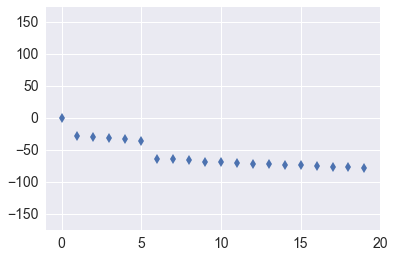

In [96]:
sc = SpectralClustering(affinity='rbf', gamma=0.01)
sc.fit_predict(data.T)
A = generate_laplacian(pd.DataFrame(sc.affinity_matrix_))
D,V = spla.eigh(A)
plt.plot(np.sort(D)[::-1][:20], "d")
ax = plt.gca()
ax.set_xbound(-1,20)
ax.set_ybound(D[25], -D[25])

Perform Spectral Clustering with Radial Basis Function similarity. We evaluate in the following the resulting similarity matrix and the cluster assignment.

In [97]:
sc = SpectralClustering(n_clusters=6, affinity='rbf', gamma=0.01, n_init=100)
df_rbf = pd.DataFrame({'assignment': sc.fit_predict(data.T)}, index =data.columns)
similarity = pd.DataFrame(generate_laplacian(pd.DataFrame(sc.affinity_matrix_)), index =data.columns, 
                                                columns=data.columns)
df_metrics, clusters, weights = compute_cluster_frames(df_rbf, data, similarity)
df_rbf.assignment.value_counts()

1    84
2    73
0    72
3    42
4    30
5    12
Name: assignment, dtype: int64

### Evaluate Clustering Results

heatmap of initial similatiry matrix and re-ordered similarity matrix reveals underlying block structure.

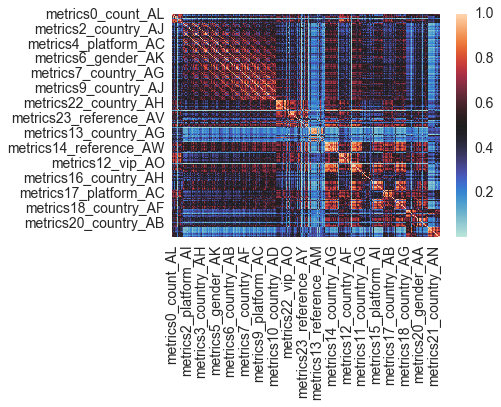

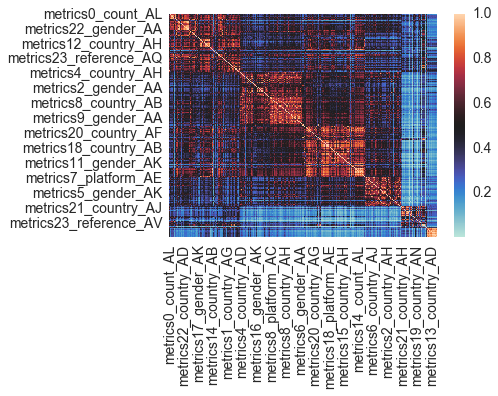

In [84]:
compare_ordering(df_rbf, pd.DataFrame(sc.affinity_matrix_,index=similarity.index, columns=similarity.columns))

Average deviation from cluster mean indicates clustering quality.

In [85]:
avg_cluster_variance = cluster_scores(df_metrics, clusters, data)
print(avg_cluster_variance)

0.140817294656


For interpretation of results we need insight which metrics were clustered together.

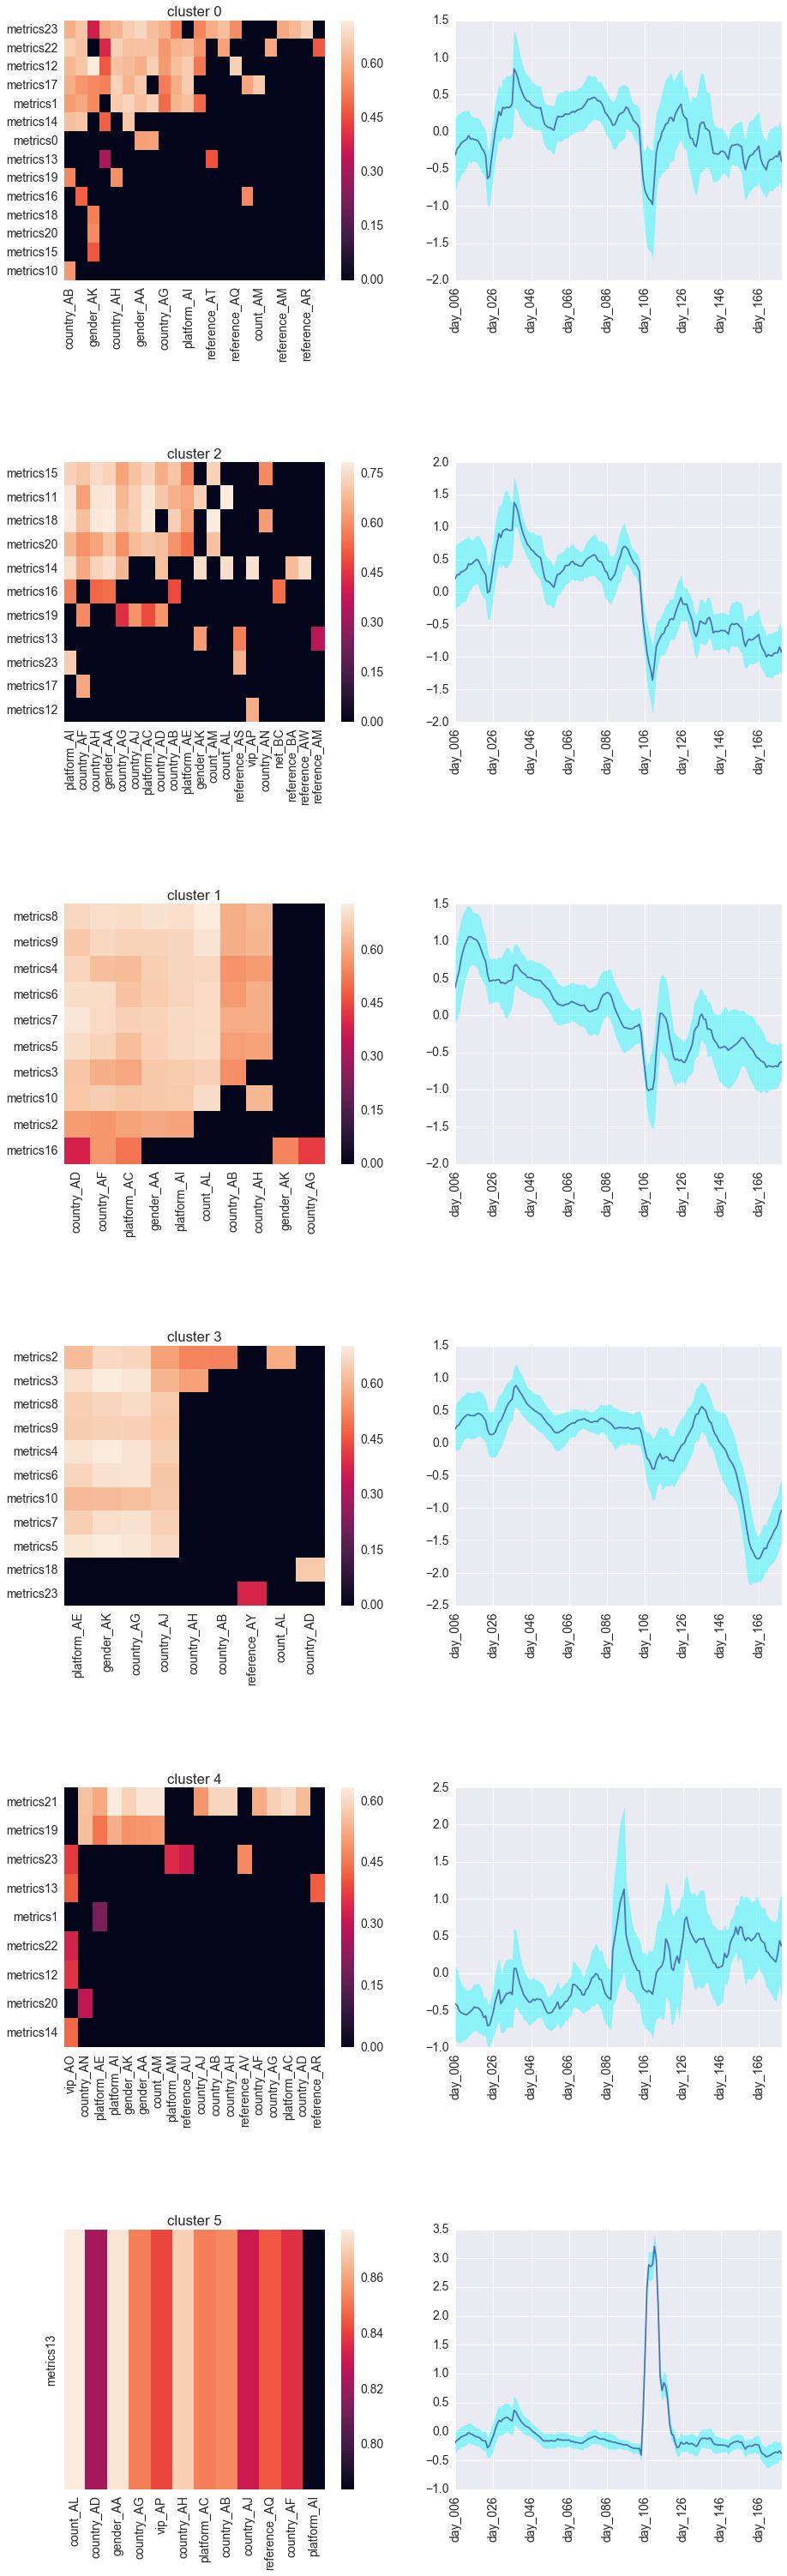

In [86]:
df_metrics, clusters = show_clusters(df_metrics, clusters, weights, data)


### Comparison with precomputed similarity based on correlation

In [87]:
# remove overall platform dynamics first and then compute correlation matrix
def platform_dynamics_corr(df):
    platform_dynamics = df.mean(axis=1)
    return (df.T - platform_dynamics).T.corr()


In [88]:
# precomputed
C = platform_dynamics_corr(data) 
similarity = 0.5 * ( C + C.abs())
#similarity =(C - C.min().min())/(1 - C.min().min())
sc = SpectralClustering(n_clusters=6, affinity='precomputed', n_init=500)
df_corr = pd.DataFrame({'assignment': sc.fit_predict(similarity)}, index =data.columns)
df_metrics, clusters, weights = compute_cluster_frames(df_corr, data, similarity)
df_corr.assignment.value_counts()

3    74
2    64
5    63
4    43
1    36
0    33
Name: assignment, dtype: int64

0.15287198288


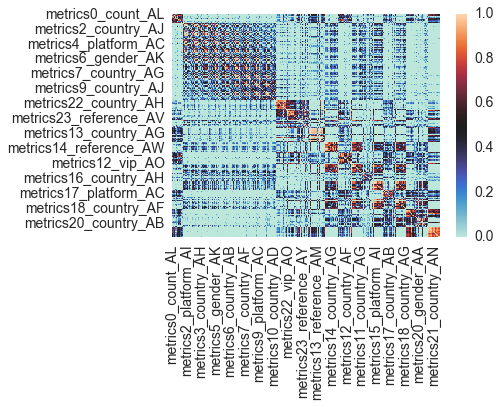

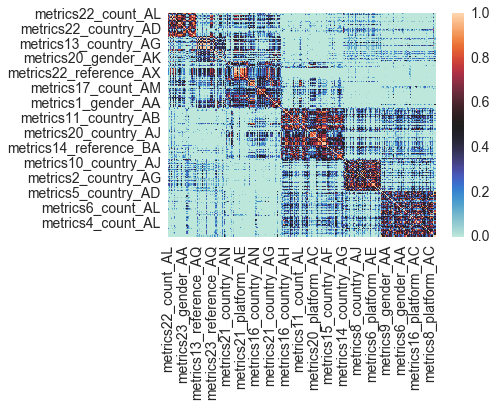

In [89]:
compare_ordering(df_corr, pd.DataFrame(sc.affinity_matrix_,index=C.index, columns=C.columns))

avg_cluster_variance = cluster_scores(df_metrics, clusters, data)
print(avg_cluster_variance)

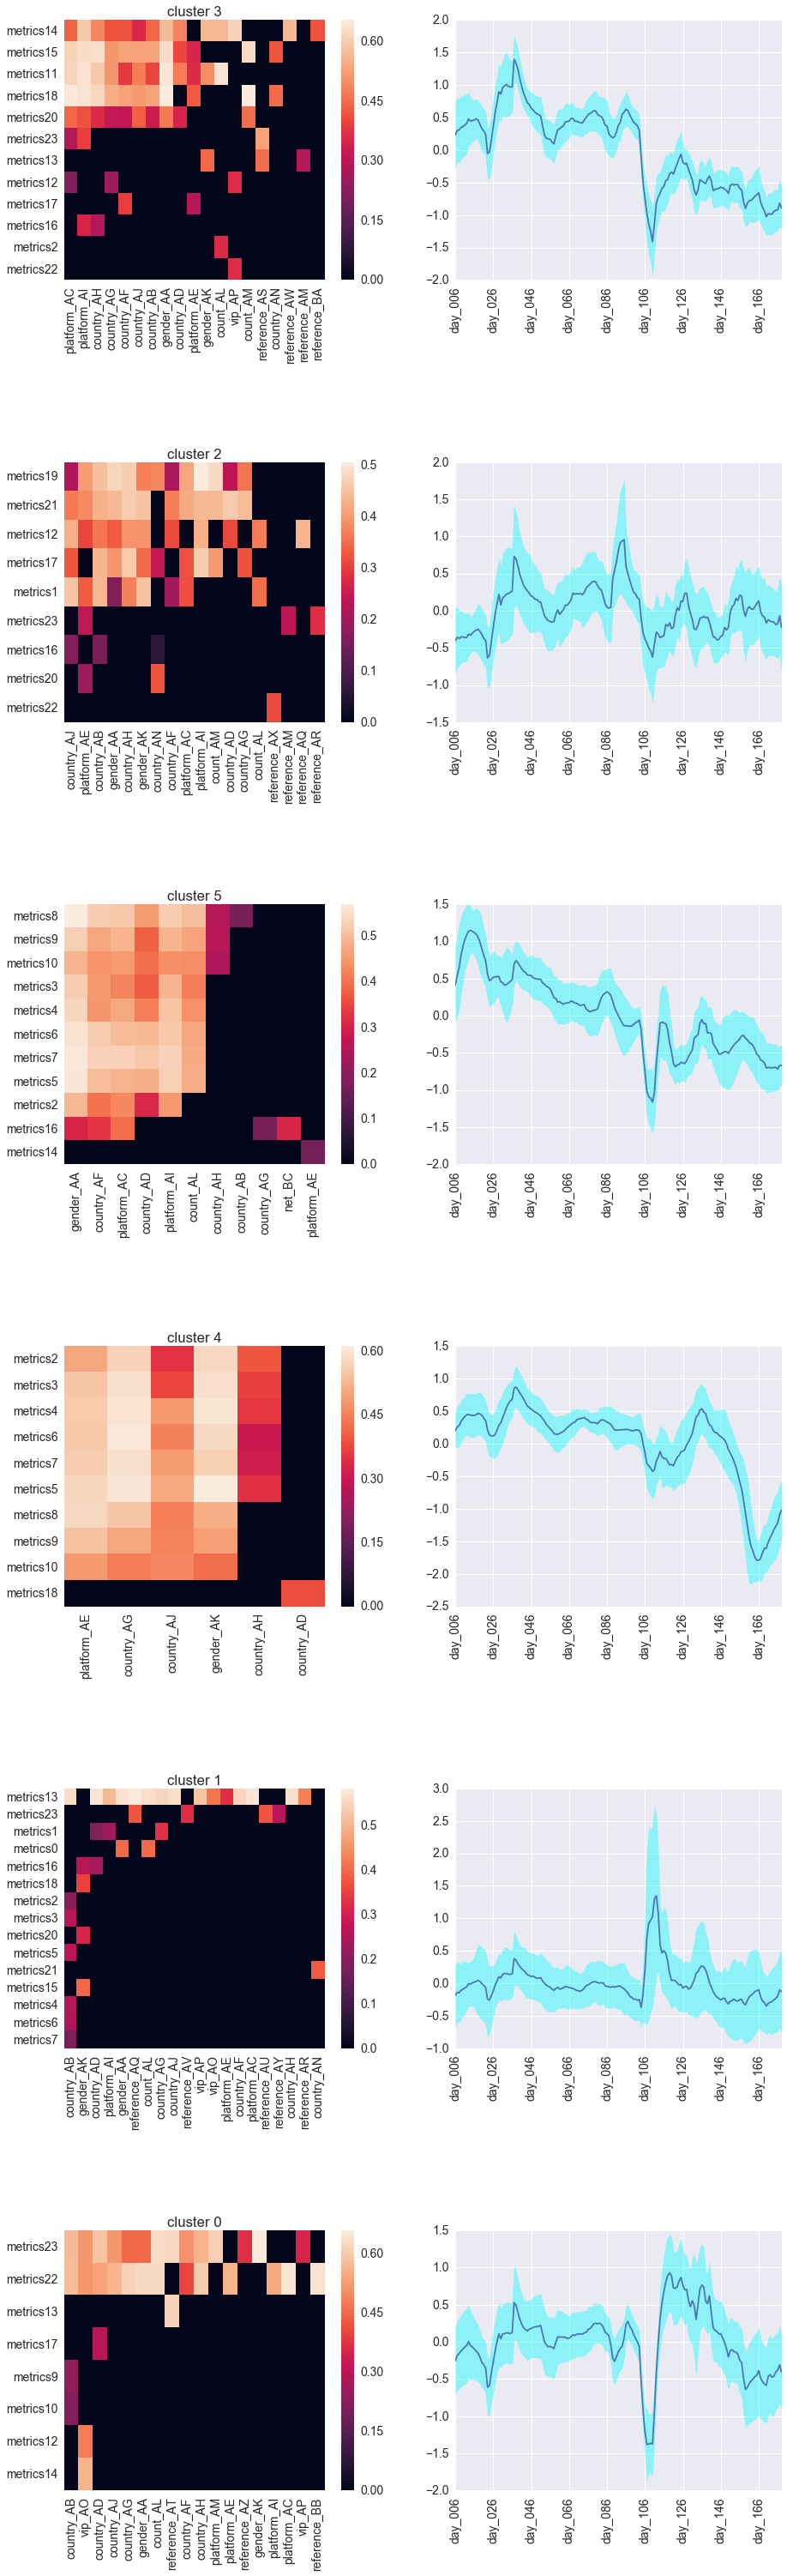

In [90]:
_,_ = show_clusters(df_metrics, clusters, weights, data)

In [91]:
avg_cluster_variance = cluster_scores(df_metrics, clusters, data)
print(avg_cluster_variance)

0.15287198288


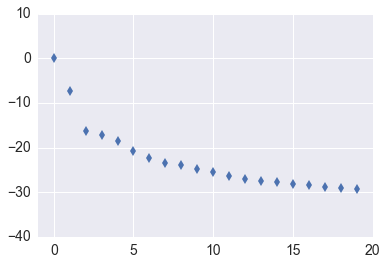

In [92]:
A = generate_laplacian(pd.DataFrame(sc.affinity_matrix_))
D,V = spla.eig(A)
plt.plot(np.sort(D)[::-1][:20], "d")
ax = plt.gca()
ax.set_xbound(-1,20)
ax.set_ybound(-40, 10)
